In [216]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import glob

In [217]:
# Load data
def load_data(data_path):
    if os.path.isfile(data_path):
        data = np.genfromtxt(data_path, names=True, delimiter=",")
        return data
    else:
        return None
    
def load_csv_files(directory, data_type, data_dict):
    csv_files = glob.glob(os.path.join(directory, '*' + data_type + '.csv'))

    if data_dict is None:
        data_dict = {}

    for csv_file in csv_files:
        label = os.path.splitext(os.path.basename(csv_file))[0]
        if label.startswith("_"):
            continue
        data = load_data(csv_file)
        label = label[:label.rfind(data_type)-1]
        data_dict[label] = data

    if len(data_dict) == 0:
        print("Failed to load any data!")

def filter_nan(data_dict):
    for label, data in data_dict.items():
        data_clean = data[~np.isnan(data["stability"])]
        count_cleaned = len(data["stability"]) - len(data_clean["stability"])
        if count_cleaned > 0:
            print(f"[WARNING] {label}: Removed {count_cleaned} entries with nan stability")
            data_dict[label] = data_clean
    
folders = [
    ]
data_dict_imu = {}
data_dict_stability = {}
for folder in folders:
    load_csv_files(folder, "imu", data_dict_imu)
    load_csv_files(folder, "stability", data_dict_stability)
filter_nan(data_dict_stability)
print(f"Loaded {len(data_dict_imu)} imu datasets.")
for label, data_imu in data_dict_imu.items():
    print(label)
print(f"Loaded {len(data_dict_stability)} stability datasets.")
for label, data_imu in data_dict_stability.items():
    print(label)

[WARNING] beginner_wb_assistance_trial-1: Removed 2 entries with nan stability
[WARNING] beginner_wb_assistance_trial-2: Removed 3 entries with nan stability
[WARNING] intermediate_wb_assistance_trial-1: Removed 1 entries with nan stability
Loaded 30 imu datasets.
autonomy_trial-0
autonomy_trial-1
autonomy_trial-2
beginner_guided_teleop_trial-0
beginner_guided_teleop_trial-1
beginner_guided_teleop_trial-2
beginner_teleop_trial-0
beginner_teleop_trial-1
beginner_teleop_trial-2
beginner_wb_assistance_trial-0
beginner_wb_assistance_trial-1
beginner_wb_assistance_trial-2
intermediate_guided_teleop_trial-0
intermediate_guided_teleop_trial-1
intermediate_guided_teleop_trial-2
intermediate_teleop_trial-0
intermediate_teleop_trial-1
intermediate_teleop_trial-2
intermediate_wb_assistance_trial-0
intermediate_wb_assistance_trial-1
intermediate_wb_assistance_trial-2
expert_guided_teleop_trial-0
expert_guided_teleop_trial-1
expert_guided_teleop_trial-2
expert_teleop_trial-0
expert_teleop_trial-1
e

In [218]:
def compute_binned_stability(travelled_distance, stability, bin_size):
    # Define bin edges
    min_distance = travelled_distance.min()
    max_distance = travelled_distance.max()
    bins = np.arange(min_distance, max_distance + bin_size, bin_size)
    # print(bins)

    # Assign each travelled_distance value to a bin
    bin_indices = np.digitize(travelled_distance, bins)

    # Calculate the average stability for each bin
    binned_stability = np.zeros(len(bins) - 1)
    for i in range(1, len(bins)):
        indices = np.where(bin_indices == i)[0]
        if indices.size > 0:
            binned_stability[i-1] = np.mean(stability[indices])
        else:
            print(f"[WARNING] Bin ({bins[i-1]},{bins[i]}) is empty")

    bin_values = bins[0:len(bins)-1] + bin_size / 2.0

    # The binned_stability dictionary now contains the average stability values for each bin
    # print(bin_values)
    # print(binned_stability)
    # for bin_range, avg_stability in binned_stability.items():
    #     print(f"Bin {bin_range}: Average Stability = {avg_stability}")

    return bin_values, binned_stability

def compute_moving_average_over_distance(travelled_distance, stability, window_distance=1.0):
    # Initialize the list to hold the running averages
    running_averages = np.empty_like(stability)

    # Compute running average with a 1m window
    for i in range(len(travelled_distance)):
        # Determine the start and end of the window
        start_distance = travelled_distance[i] - window_distance / 2
        end_distance = travelled_distance[i] + window_distance / 2
        
        # Find indices where distances fall within the window
        window_indices = np.where((travelled_distance >= start_distance) & (travelled_distance <= end_distance))[0]
        
        # Compute the average stability for these indices
        running_averages[i] = np.mean(stability[window_indices])
    return running_averages

def moving_average(data, size):
    window = np.ones(int(size)) / float(size)
    return np.convolve(data, window, 'same')




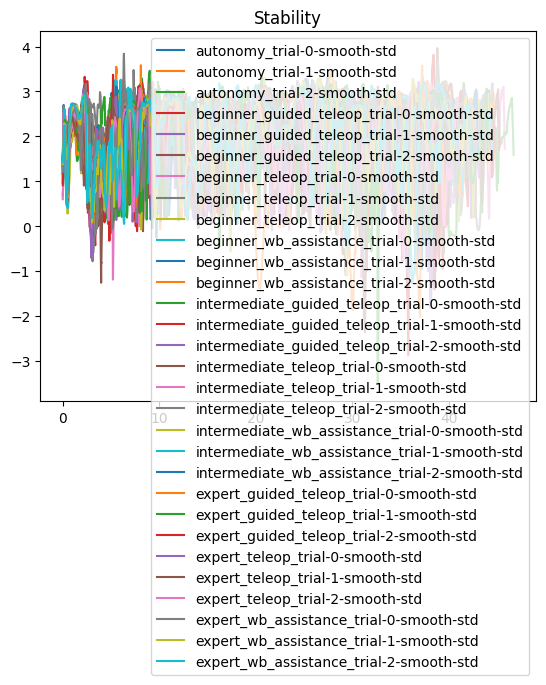

In [219]:
# Stability plot
# Raw relative probability per sample
fig, ax = plt.subplots()
ax.title.set_text("Stability")
for label, data in data_dict_stability.items():

    # bin_size = 0.15
    # bin_values, binned_stability = compute_binned_stability(data["travelled_distance"], data["stability"], bin_size)
    # ax.bar(bin_values, binned_stability, width=bin_size)


    # ax.plot(data["travelled_distance"], data["stability"], label=label)
    
    # smoothed_stability = compute_moving_average_over_distance(data["travelled_distance"], data["stability"], window_distance=0.25)
    # ax.plot(data["travelled_distance"], smoothed_stability, label=label + "-smooth")
    smoothed_stability_standard = moving_average(data["stability"], size=9)
    ax.plot(data["travelled_distance"], smoothed_stability_standard, label=label + "-smooth-std")

ax.legend()
plt.show()

In [220]:
def compute_statistics(array, label: str):
    avg = np.mean(array)
    sum = np.sum(array)
    maximum = np.max(array)
    percentile = np.percentile(array, 99)
    # print(f" -- Avg. {label}: {avg:.2f}, Acc. {label}: {sum:.2f}, Max. {label}: {maximum:.2f}, Perc. {label}: {percentile:.2f}") 
    return avg, sum, maximum, percentile

def compute_integral(time, data):
    return np.trapz(data, time)

def compute_smoothness_metric(x, y, z, calibration, min, max):
    vec = np.stack((x, y, z), axis=0)
    norm = np.linalg.norm(vec, axis=0) - calibration
    norm = np.maximum(norm, min)
    norm = np.minimum(norm, max)
    return norm*norm 

def compute_shock(acc_x, acc_y, acc_z):
    calibration = 10.0 # only consider hard hits
    gravity = 9.81
    return compute_smoothness_metric(acc_x, acc_y, acc_z, calibration + gravity, 0, 50.0)

def compute_swing(vel_x, vel_y):
    calibration = 0.5 # only consider fast swings
    return compute_smoothness_metric(vel_x, vel_y, np.zeros_like(vel_x), calibration, 0, 3.0)

# Compute trial metrics
def compute_metrics(data_imu, data_stability):
    # time
    duration = max(data_imu["time"][-1], data_stability["time"][-1])
    # print(f" -- Duration: {duration:.2f}s")

    # Average stability
    avg_stability = np.mean(data_stability["stability"])
    # _, binned_stability = compute_binned_stability(data_stability["travelled_distance"], data_stability["stability"], 0.12)
    # avg_binned_stability = np.mean(binned_stability)
    # smoothed_stability = compute_moving_average_over_distance(data_stability["travelled_distance"], data_stability["stability"], window_distance=1.0)
    # smoothed_stability = moving_average(data_stability["stability"], size=5)
    # avg_smoothed_stability = np.mean(smoothed_stability)
    # print(f" -- Avg. stability: {avg_stability:.2f}, avg. binned stability: {avg_binned_stability:.2f}, avg. smoothed stability: {avg_smoothed_stability:.2f}")

    # Locomotion roughness
    shock = compute_shock(data_imu["linear_acceleration_x"], data_imu["linear_acceleration_y"], data_imu["linear_acceleration_z"])
    # avg_shock, sum_shock, max_shock, percentile_shock = compute_statistics(shock, "shock")
    int_shock = compute_integral(data_imu["time"], shock)

    swing = compute_swing(data_imu["angular_velocity_x"], data_imu["angular_velocity_y"])
    # avg_swing, sum_swing, max_swing, percentile_swing = compute_statistics(swing, "swing")
    int_swing = compute_integral(data_imu["time"], swing)

    return duration, avg_stability, int_shock, int_swing

def print_results(result_data):
    for label, trials in result_data.items():
        print("Mode:", label)
        print("Duration Stability Shock Swing")
        for i, trial in enumerate(trials):
            metrics_str = ', '.join(str(np.around(num, decimals=2)) for num in trial)
            print(metrics_str)
        trials_matrix = np.array(trials)
        avg = np.mean(trials_matrix, axis=0)
        print(f"Avg:     {', '.join(str(np.around(num, decimals=2)) for num in avg)}")

        print("")


result_data = dict()
for label, data_imu in data_dict_imu.items():
    # print(f"Trial {label} metrics:")
    data_stability = data_dict_stability[label]
    metrics = compute_metrics(data_imu, data_stability)
    mode = label[:label.rfind("trial") -1]
    if mode in result_data:
        result_data[mode].append(metrics)
    else:
        result_data[mode] = []
        result_data[mode].append(metrics)

print_results(result_data)

Mode: autonomy
Duration Stability Shock Swing
311.99, 1.97, 111.88, 1.71
322.43, 2.01, 120.33, 1.83
315.95, 2.0, 159.13, 1.87
Avg:     316.79, 1.99, 130.45, 1.8

Mode: beginner_guided_teleop
Duration Stability Shock Swing
324.71, 1.79, 201.91, 2.08
293.87, 1.73, 108.75, 1.82
264.99, 1.76, 227.36, 2.47
Avg:     294.53, 1.76, 179.34, 2.12

Mode: beginner_teleop
Duration Stability Shock Swing
436.01, 1.82, 134.35, 2.62
328.79, 1.69, 194.04, 3.19
326.61, 1.69, 179.05, 1.98
Avg:     363.81, 1.73, 169.15, 2.6

Mode: beginner_wb_assistance
Duration Stability Shock Swing
188.55, 2.03, 251.77, 3.86
177.29, 1.94, 407.13, 4.33
186.24, 1.85, 392.54, 7.44
Avg:     184.03, 1.94, 350.48, 5.21

Mode: intermediate_guided_teleop
Duration Stability Shock Swing
349.63, 1.75, 224.7, 2.78
237.93, 1.7, 151.21, 1.26
207.75, 1.76, 197.49, 3.09
Avg:     265.11, 1.74, 191.13, 2.37

Mode: intermediate_teleop
Duration Stability Shock Swing
290.17, 1.67, 232.32, 2.34
204.35, 1.79, 323.16, 3.48
175.33, 1.84, 163.01,

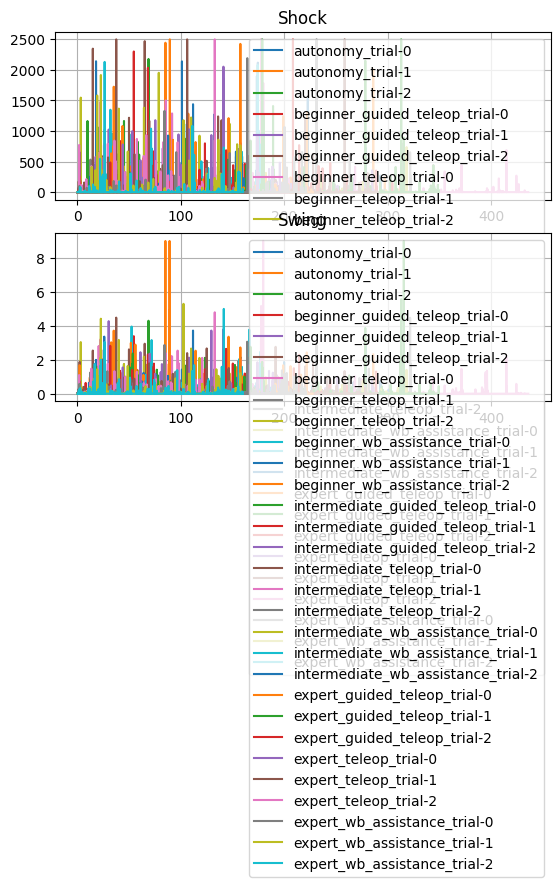

In [221]:
fig, axs = plt.subplots(2, 1)
axs[0].title.set_text("Shock")
axs[1].title.set_text("Swing")
for label, data in data_dict_imu.items():
    shock = compute_shock(data["linear_acceleration_x"], data["linear_acceleration_y"], data["linear_acceleration_z"])
    axs[0].plot(data["time"], shock, label=label)

    swing = compute_swing(data["angular_velocity_x"], data["angular_velocity_y"])
    swing = np.maximum(swing, 0.0)

    axs[1].plot(data["time"], swing, label=label)
    # axs[1].plot(data["time"], data["angular_velocity_z"])

for ax in axs:
    ax.legend()
    ax.grid()


Bins [150 200 250 300 350]


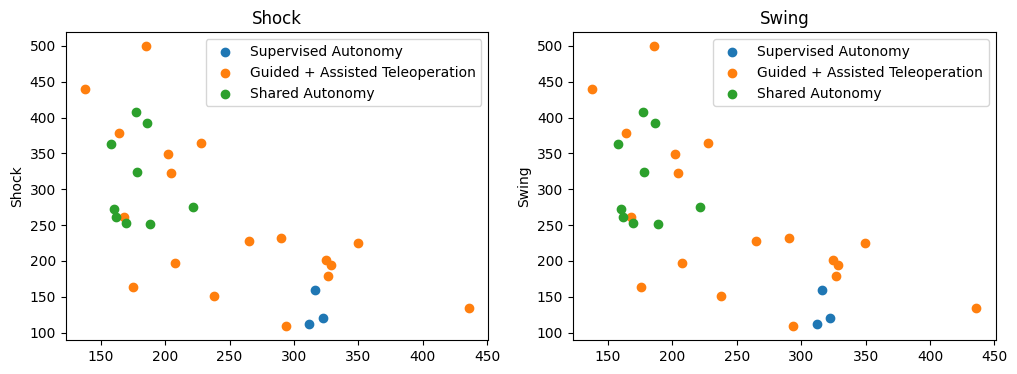

In [222]:
# Per mode: scatter plot of shock/swing over time

# Collect data per mode
modes = ["autonomy", "teleop", "wb_assistance",]
mode_labels = {
    "autonomy": "Supervised Autonomy",
    "teleop": "Guided + Assisted Teleoperation",
    "wb_assistance": "Shared Autonomy",
}
mode_results_dict = dict()
for label, trials in result_data.items():
    trials_matrix = np.array(trials)
    for mode in modes:
        if mode in label:
            if mode in mode_results_dict:
                stacked = np.concatenate((mode_results_dict[mode], trials_matrix), axis=0)
                mode_results_dict[mode] = stacked
            else:
                mode_results_dict[mode] = trials_matrix
# print(mode_results_dict["wb_assistance"][:, 0].min(), mode_results_dict["wb_assistance"][:, 0].max())


# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bins = np.array([150, 200, 250, 300, 350])
# bins = np.arange(150, 400, 60)
# bins = np.array([mode_results_dict["wb_assistance"][:, 0].min(), mode_results_dict["wb_assistance"][:, 0].max()])
# bins = np.arange(0, 500, 25)
print("Bins", bins)
for i, (mode, results) in enumerate(mode_results_dict.items()):
    axs[0].set_title("Shock")
    axs[0].scatter(results[:, 0], results[:, 2], label=mode_labels[mode])
    axs[0].set_ylabel("Shock")

    axs[1].set_title("Swing")
    axs[1].scatter(results[:, 0], results[:, 2], label=mode_labels[mode])
    axs[1].set_ylabel("Swing")

for ax in axs:
    ax.legend()

Bins [150 200 250 300 350]


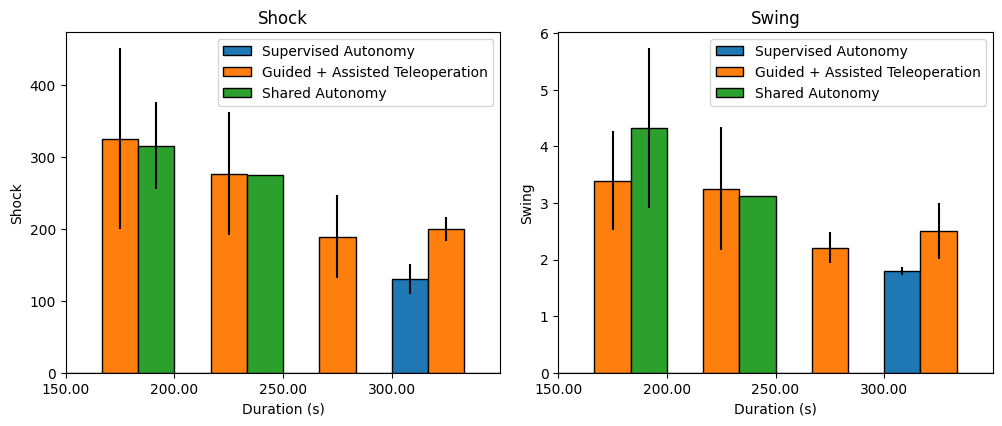

In [223]:
def plot_avg_histogram(ax, duration, metric, bins, bar_index, total_bars, label):
    indices = np.digitize(duration, bins) - 1  # Find which bin each time value falls into
    n_bins = len(bins) -1
    # Compute average shock values for each bin
    avg_shocks = np.array([metric[indices == i].mean() if len(metric[indices == i]) > 0 else 0 for i in range(n_bins)])
    std_dev = np.array([metric[indices == i].std() if len(metric[indices == i]) > 0 else 0 for i in range(n_bins)])

    # Plot
    x = np.arange(n_bins)
    default_bar_width = 1.0
    bar_width = default_bar_width / total_bars
    ax.bar(x + bar_index * bar_width, avg_shocks, width=bar_width, yerr=std_dev, edgecolor='black', align='edge', label=label)

    ax.set_xticks(x , labels=[f"{bins[i]:.2f}" for i in range(n_bins)])
    ax.set_xlabel('Duration (s)')
    ax.set_xlim(0, n_bins)
    # ax.set_ylim(0, avg_shocks.max() * 1.5)
    # ax.set_title('Average Shock per Time Bin')


# Plot
fig2, axs2 = plt.subplots(1, 2, figsize=(10, 4))
fig2.tight_layout()
bins = np.array([150, 200, 250, 300, 350])
# bins = np.arange(150, 400, 60)
# bins = np.array([mode_results_dict["wb_assistance"][:, 0].min(), mode_results_dict["wb_assistance"][:, 0].max()])
# bins = np.arange(0, 500, 25)
print("Bins", bins)
for i, mode in enumerate(modes):
    results = mode_results_dict[mode]
    axs2[0].set_title("Shock")
    plot_avg_histogram(axs2[0], results[:, 0], results[:, 2], bins, i, len(mode_results_dict), label=mode_labels[mode])
    axs2[0].set_ylabel("Shock")

    axs2[1].set_title("Swing")
    plot_avg_histogram(axs2[1], results[:, 0], results[:, 3], bins, i, len(mode_results_dict), label=mode_labels[mode])
    axs2[1].set_ylabel("Swing")

for ax in axs2:
    ax.legend()

plt.savefig("export/locomotion_smoothness_over_time", dpi=300, bbox_inches = "tight")





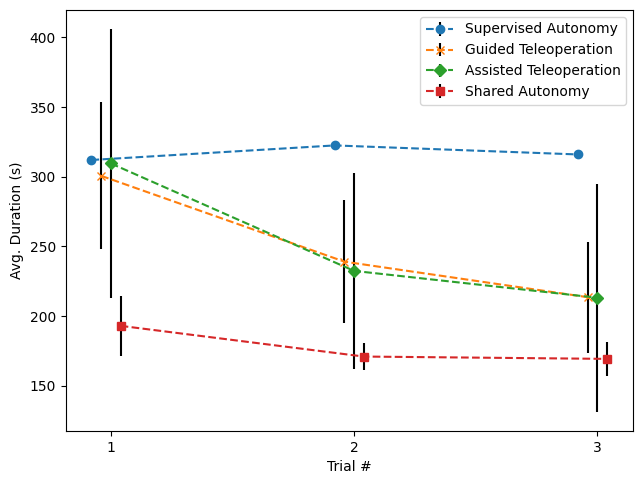

In [224]:
# plot with average time over trials per mode
# x-axis: trial #
# y-axis: avg duration per trial #
# 4 lines + scatter for each mode

# collect data
modes = ["autonomy", "guided_teleop", "teleop", "wb_assistance",]
mode_labels = {
    "autonomy": "Supervised Autonomy",
    "teleop": "Assisted Teleoperation",
    "guided_teleop": "Guided Teleoperation",
    "wb_assistance": "Shared Autonomy",
}
trail_comp_dict = dict()
for label, trials in result_data.items():
    trials_matrix = np.array(trials)
    for mode in modes:
        if mode in label:
            trial_durations = trials_matrix[:, 0:1]
            if mode in trail_comp_dict:
                concat = np.concatenate((trail_comp_dict[mode], trial_durations), axis=1)
                trail_comp_dict[mode] = concat
            else:
                trail_comp_dict[mode] = trial_durations
            break


# plot
fig, ax = plt.subplots()
fig.tight_layout()
markers = ["o", "x", "D", "s"]
max_trials = 0
for _, results in trail_comp_dict.items():
    trials_num = results.shape[0]
    if trials_num > max_trials:
        max_trials = trials_num
x = np.arange(1, max_trials + 1, 1)
for i, ((mode, results), marker) in enumerate(zip(trail_comp_dict.items(), markers)):
    if results.shape[1] > 1:
        y = np.mean(results, axis=1)
        y_err = np.std(results, axis=1)
    else:
        y = results.transpose()[0]
        y_err = np.zeros_like(y)
    offset = 0.04
    x_offset = x + offset * (i - len(modes) / 2.0)
    ax.errorbar(x_offset, y, yerr=y_err, label=mode_labels[mode], fmt='--'+marker, ecolor="black")

ax.legend()
# ax.set_title("")
ax.set_xticks(x)
ax.set_xlabel("Trial #")
ax.set_ylabel("Avg. Duration (s)")
# ax.set_ylim(140, 500)
plt.savefig("export/trial_comparison", dpi=300, bbox_inches = "tight")

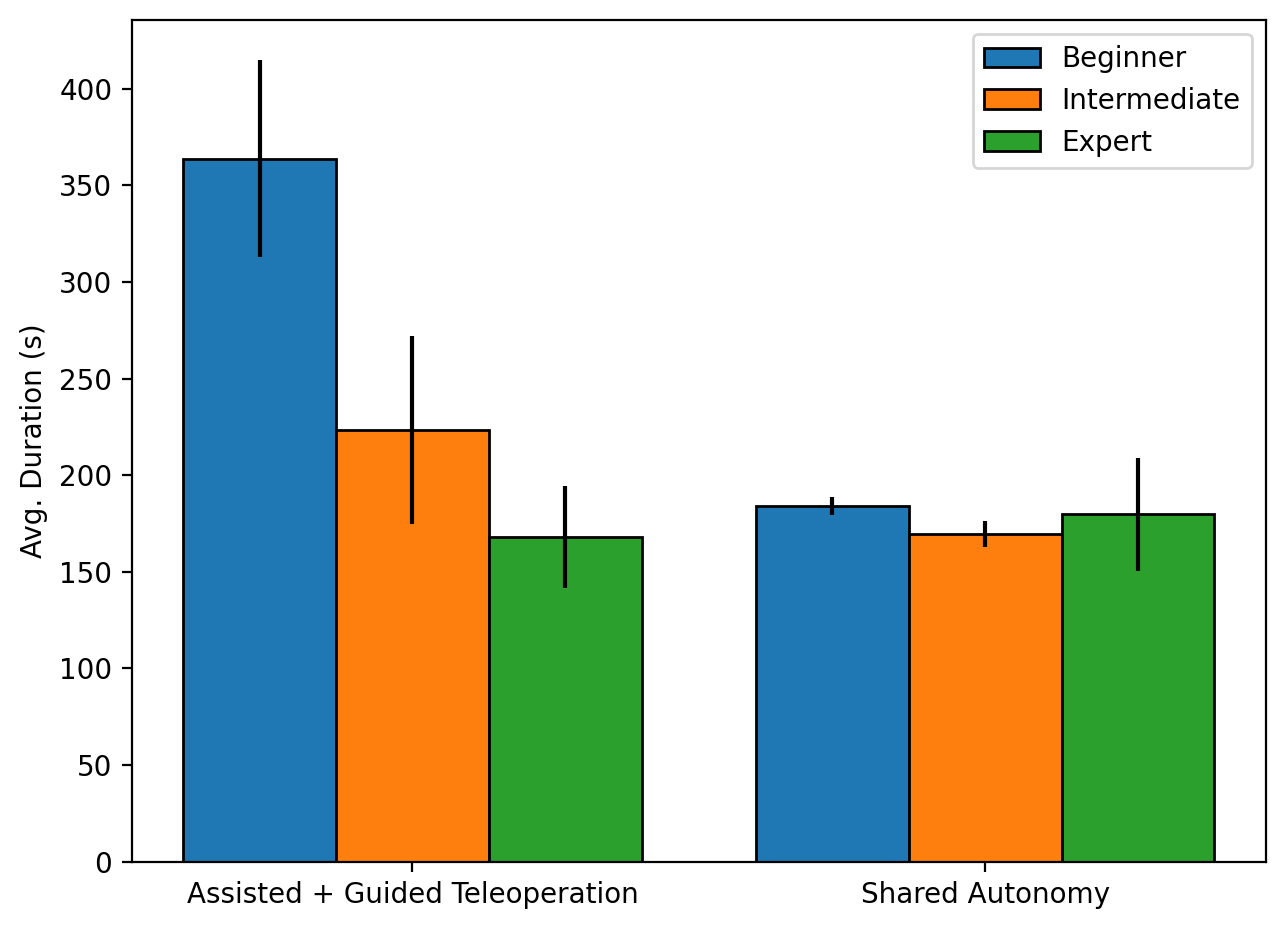

In [244]:
# operator experience comparison
# plot x-axis: experience (operators)
# y-axis avg duration per mode, four lines

# collect data
modes = ["teleop", "wb_assistance",]
mode_labels = {
    "autonomy": "Supervised Autonomy",
    "teleop": "Assisted + Guided Teleoperation",
    "guided_teleop": "Guided Teleoperation",
    "wb_assistance": "Shared Autonomy",
}

operator_experience = ["beginner", "intermediate", "expert"]
operator_experience_labels = {
    "beginner": "Beginner",
    "intermediate": "Intermediate",
    "expert": "Expert",
}

operator_comp_dict = dict()
for exp in operator_experience:
    operator_comp_dict[exp] = np.zeros((3, len(modes)))

for label, trials in result_data.items():
    trials_matrix = np.array(trials)
    for exp in operator_experience:
        if exp in label:
            trial_durations = trials_matrix[:, 0:1]
            # find mode index
            for i, mode in enumerate(modes):
                if mode in label:
                    mode_index = i
                    break
                if i == len(modes) - 1:
                    print("[WARN] Could not find mode in", label)

            operator_comp_dict[exp][:, mode_index:mode_index+1] = trial_durations[:]
            break

# print(operator_comp_dict)

# plot

fig, ax = plt.subplots(dpi=200)
fig.tight_layout()

x = np.arange(0, len(modes), 1)
default_bar_width = 0.8
bar_width = default_bar_width / len(operator_experience)
for i, (op_exp, results) in enumerate(operator_comp_dict.items()):
    y = np.mean(results, axis=0)
    # print(op_exp, y)
    y_err = np.std(results, axis=0)
    x_offset = x + (i - len(operator_experience) / 2.0) * bar_width
    ax.bar(x_offset, y, width=bar_width, yerr=y_err, edgecolor='black', align='edge', label=operator_experience_labels[op_exp])

ax.legend()
ax.set_xticks(x , labels=[mode_labels[modes[i]] for i in range(len(modes))])
ax.set_ylabel("Avg. Duration (s)")

plt.savefig("export/operator_comparison", dpi=300, bbox_inches = "tight")
plt.show()